In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.datasets as dsets
from torchvision.transforms import ToPILImage
from PIL import Image
import matplotlib.pylab as plt
import os

In [2]:
def get_names(name): # get names of labels from folders
  folder_names = {}
  for i, folder_name in enumerate(os.listdir(name),0):
      if os.path.isdir(os.path.join(name, folder_name)):
          folder_names[i] = folder_name[4:]
  return folder_names

In [3]:
def show_sample(train_loader):
  count = 0
  for images, labels in train_loader:
      image = images[0]
      label = labels[0]
      print(f"Label: {label}")
      plt.imshow(image.permute(1, 2, 0))
      plt.show()
      count += 1
      if count == 3:
        break

In [4]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

model

In [5]:
class CNN(nn.Module):
    def __init__(self,out_1=2,out_2=4, out_3=4):
        """ Function for creating convolutional neural network model
    
        Parameters:
        out_1 (int): filters amount
        out_2 (int): filters amount
        out_3 (int): filters amount

        Returns:
        None: -
        """
        super(CNN,self).__init__()
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=out_1,kernel_size=2,padding=0)
        self.maxpool1=nn.MaxPool2d(kernel_size=2 ,stride=1)

        self.cnn2=nn.Conv2d(in_channels=out_1,out_channels=out_2,kernel_size=2,stride=1,padding=0)
        self.maxpool2=nn.MaxPool2d(kernel_size=2 ,stride=1)

        self.cnn3=nn.Conv2d(in_channels=out_2,out_channels=out_3,kernel_size=4,stride=2,padding=0)
        self.maxpool3=nn.MaxPool2d(kernel_size=4 ,stride=2)

        self.fc1=nn.Linear(out_3 * 13 * 13,164)
        
    def forward(self,x):
        x=torch.relu(self.cnn1(x))
        x=self.maxpool1(x)
        x=torch.relu(self.cnn2(x))
        x=self.maxpool2(x)
        x=torch.relu(self.cnn3(x))
        x=self.maxpool3(x)
        x=x.view(x.size(0),-1)
        x=self.fc1(x)
        return x

download and prepare data

there should be like this dataset:

Dataset folder:


├── person1

│   ├── person1_1.jpg

│   ├── person1_2.jpg

│   ├── person1_3.jpg

│   └── ...
...

In [6]:
# get dataset from drive
train_folder = "/home/jovyan/dataset/dataset2/train"
test_folder = "/home/jovyan/dataset/dataset2/test"

train_dataset = dsets.ImageFolder(train_folder, transform=transform)
validation_dataset = dsets.ImageFolder(test_folder, transform=transform)

train_loader=torch.utils.data.DataLoader(dataset= train_dataset, batch_size = 1)
validation_loader=torch.utils.data.DataLoader(dataset= validation_dataset, batch_size = 1)

train_labels = get_names(train_folder)
validate_labels = get_names(test_folder)


Label: 0


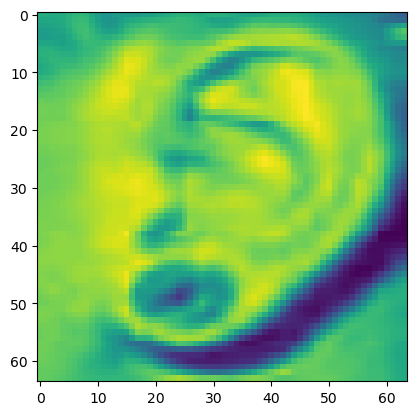

Label: 0


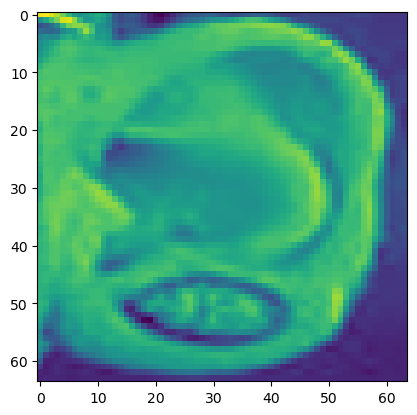

Label: 0


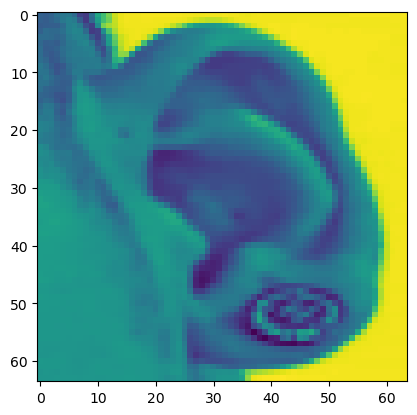

In [7]:
show_sample(train_loader)

In [8]:
# train_dataset.shape
# train_dataset[0].shape
train_dataset[0][0].shape

# train_dataset[0][1].shape
# train_dataset[1].shape

torch.Size([1, 64, 64])

In [9]:
train_dataset[0][0].shape

torch.Size([1, 64, 64])

train data function

In [10]:
model=CNN()

# model.state_dict()

criterion=nn.CrossEntropyLoss()
# TODO! use different hyperparameters
learning_rate=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(n_epochs = 10, N_test=len(validation_loader)):
  cost_list=[]
  accuracy_list=[]
  cost=0
  for epoch in range(n_epochs):
      cost=0    
      for x, y in train_loader:
          optimizer.zero_grad()
          z=model(x)
          loss=criterion(z,y)
          loss.backward()
          optimizer.step()

          cost+=loss.item()
      cost_list.append(cost)
          
      correct=0
      
      for x_test, y_test in validation_loader:
          z=model(x_test)
          _,yhat=torch.max(z.data,1)
          correct+=(yhat==y_test).sum().item()
          
      accuracy=correct/N_test

      accuracy_list.append(accuracy)
  return cost_list, accuracy_list


In [11]:
cost_list, accuracy_list = train()

analyse result

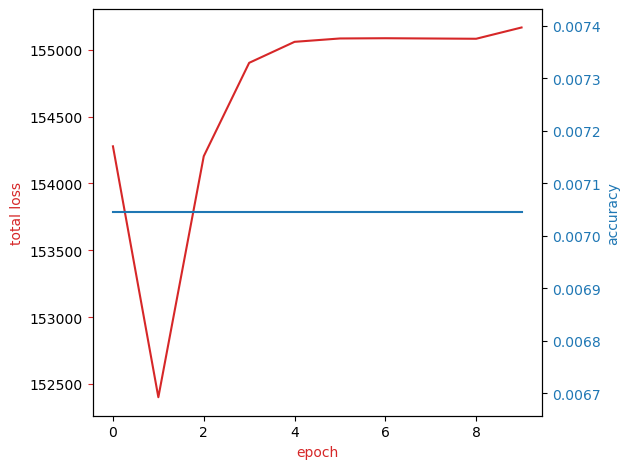

In [12]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

predict data function

In [13]:
def predict(model, known_data, unknown_data):
    with torch.no_grad():
        known_data_encoding = model(known_data.cuda())
    with torch.no_grad():
        unknown_data_encoding = model(unknown_data.cuda())

    distance = nn.PairwiseDistance(p=2)(known_data_encoding, unknown_data_encoding)
    threshold = 1.0

    return True if distance < threshold else False

known_data = Image.open("/home/jovyan/first.jpg")
unknown_data = Image.open("/home/jovyan/second.jpg")

known_data = transform(known_data)
unknown_data = transform(unknown_data)

known_data = torch.unsqueeze(known_data, dim=0)
unknown_data = torch.unsqueeze(unknown_data, dim=0)


predict(model, known_data, unknown_data)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x169 and 676x164)

In [ ]:
known_data = transform(Image.open("/home/jovyan/first.jpg"))
known_data.shape


In [ ]:
known_data = Image.open("/home/jovyan/first.jpg")
known_data = transform(known_data)
known_data = torch.unsqueeze(known_data, dim=0)
result = model(known_data)

save model

In [ ]:
torch.save(model, '/home/jovyan/save/model.pt')